In [1]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
import math
import csv

In [2]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Adjust the number of filters
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32  # Reduce the initial number of channels

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model
# cnn_model = CNN(BasicBlock, [2, 2, 2, 2]).to(device)
cnn_model = CNN(BasicBlock, [3, 4, 6, 3]).to(device)

model_weights_path = "/kaggle/input/earthcam-yolo/cnn_model_weights.pth"
cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

# Set the model to evaluation mode
cnn_model.eval()

/tmp/ipykernel_36/3140090288.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device))

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1

In [4]:
# define paths to image folders
folder_paths = {
    'New York': '/kaggle/input/earthcam-yolo/Earthcam_Images/Earthcam_Images/NewYork_resized',
    'New Orleans': '/kaggle/input/earthcam-yolo/Earthcam_Images/Earthcam_Images/NewOrleans_resized',
    'London': '/kaggle/input/earthcam-yolo/Earthcam_Images/Earthcam_Images/London_resized'
}

# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

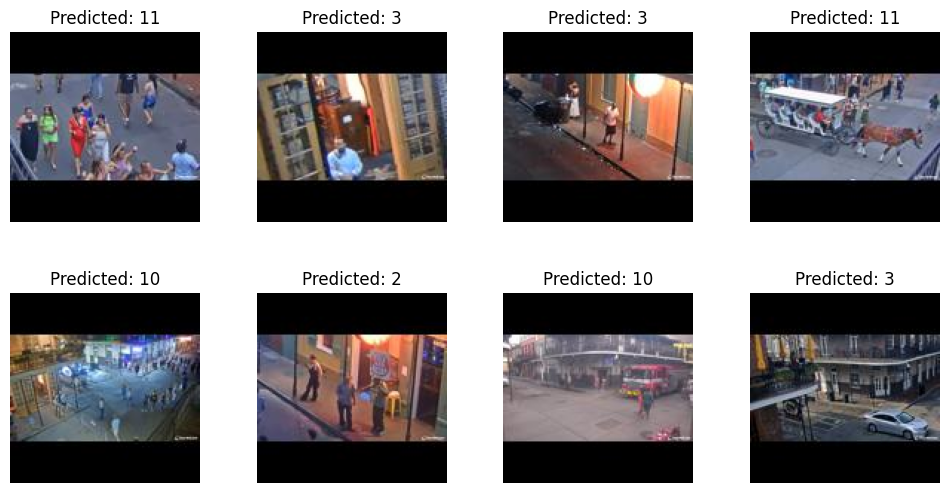

In [5]:
# visualize how model works on the images

def visualize_prediction(model, city, year, number_of_images):
    model.eval()
    
    image_dir = folder_paths[city]
    image_files = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0]
            date = parts[1]
            file_year = date.split('-')[-1]
            if file_year == year:
                image_files.append(filename)
    
    # Randomly select indices
    random_indices = random.sample(range(len(image_files)), number_of_images)
    
    rows = math.ceil(number_of_images / 4)
    cols = min(4, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, idx in enumerate(random_indices):
        filename = image_files[idx]
        image_path = os.path.join(image_dir, filename)
        
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)

        # Predict using the model
        predicted_count = model(image)
        predicted_count = torch.round(predicted_count).item()

        # Convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        # image_np = image_np * 0.5 + 0.5  # Assuming the image was normalized to [-1, 1]

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        ax.imshow(image_np)
        ax.set_title(f"Predicted: {int(predicted_count)}")
        ax.axis('off')

    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(cnn_model, "New Orleans", "2022", number_of_images=8)

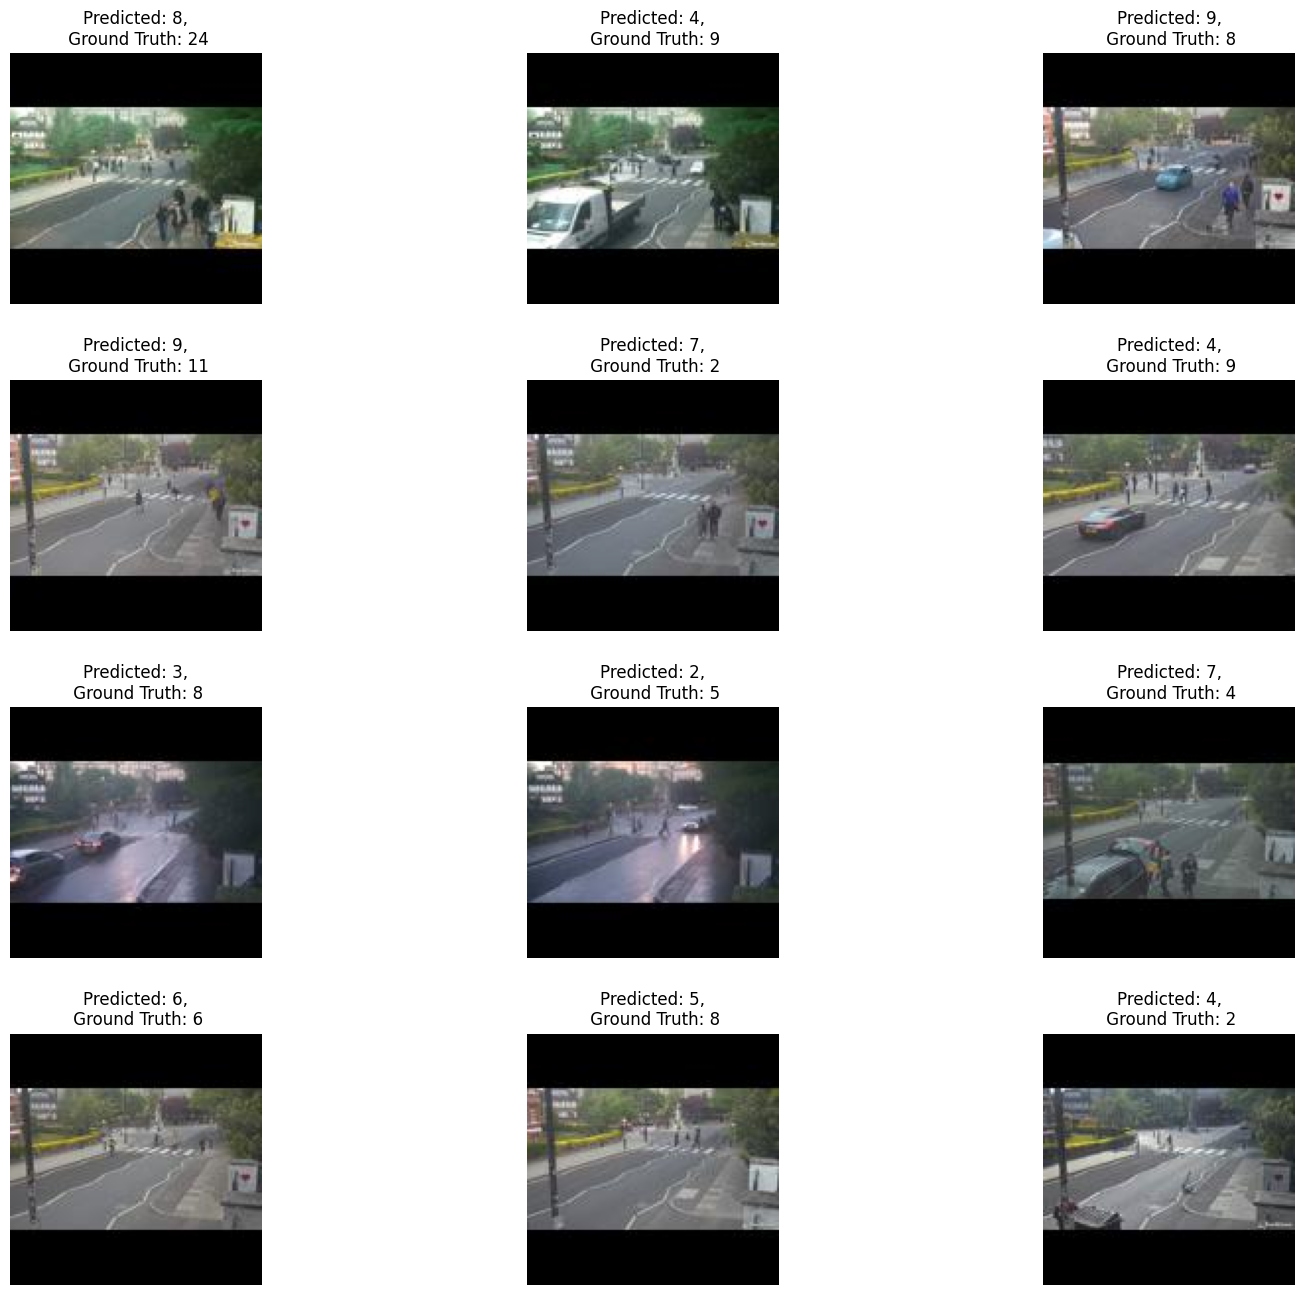

In [7]:
def load_ground_truth(file_path):
    ground_truth = {}
    with open(file_path, mode='r') as file:
        if file_path.endswith('.csv'):
            reader = csv.reader(file)
            next(reader)  # Skip the header
            for row in reader:
                filename, count = row
                ground_truth[filename] = int(count)
        elif file_path.endswith('.json'):
            ground_truth = json.load(file)
    return ground_truth

def visualize_ground_truth_predictions(model, ground_truth_file, city):
    # Load the ground truth data
    ground_truth = load_ground_truth(ground_truth_file)
    
    # Set the directory where images are stored
    image_dir = folder_paths[city]
    
    # Determine the number of images
    number_of_images = len(ground_truth)
    
    # Set up the plot grid
    rows = math.ceil(number_of_images / 3)
    cols = min(3, number_of_images)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.0)
    
    for i, (filename, gt_count) in enumerate(ground_truth.items()):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)

        # Predict using the model
        predicted_count = model(image)
        predicted_count = torch.round(predicted_count).item()

        # Convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        
        
        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]
        
        ax.imshow(image_np)
        ax.set_title(f"Predicted: {int(predicted_count)},\n Ground Truth: {gt_count}")
        ax.axis('off')
    
    plt.show()


visualize_ground_truth_predictions(cnn_model, '/kaggle/input/earthcam-yolo/ground_truth_London_filtered.csv', "London")

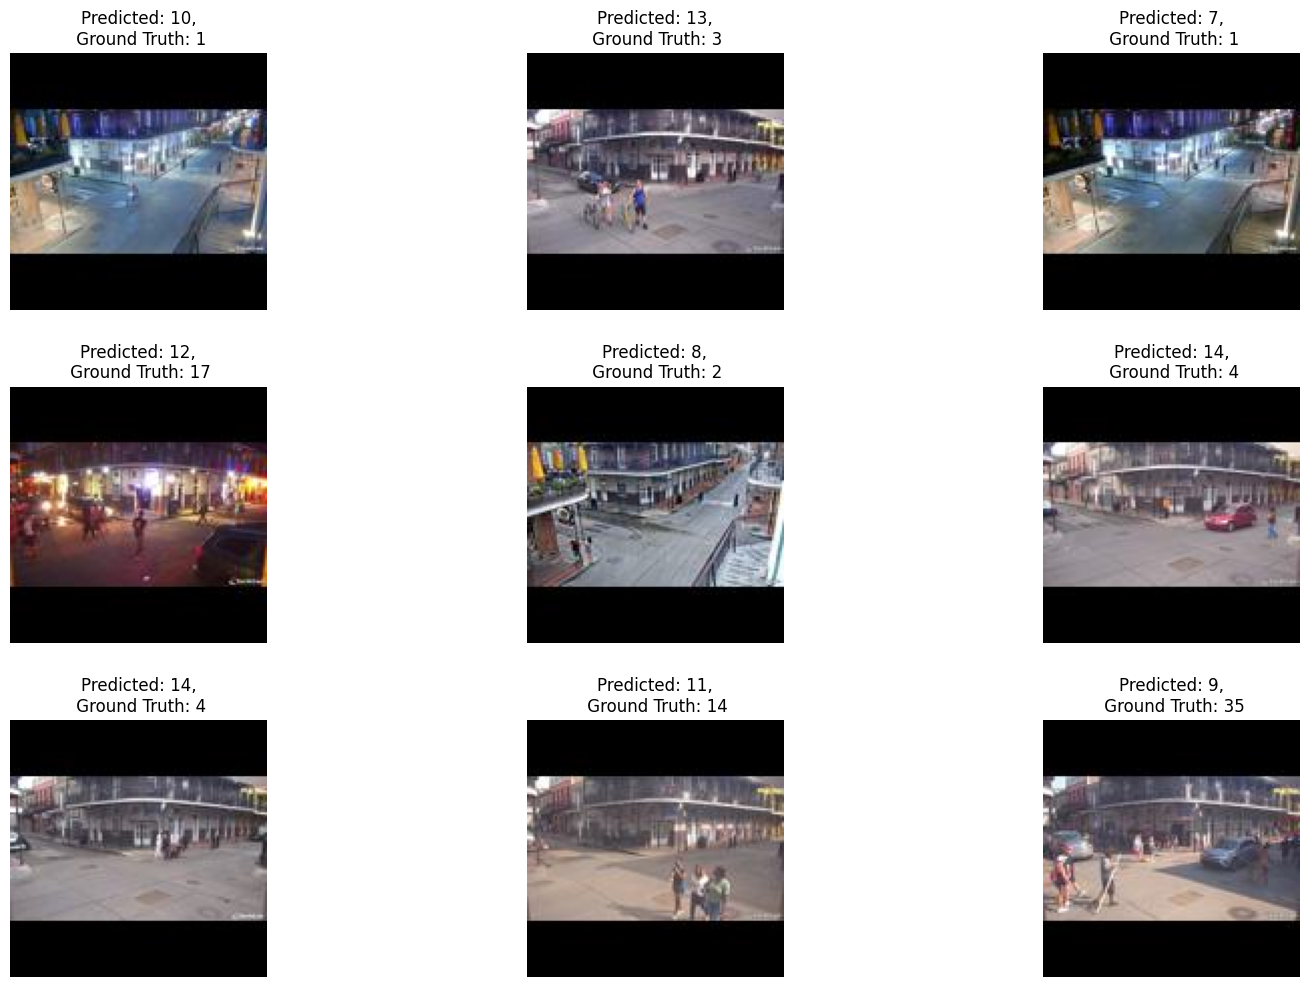

In [8]:
visualize_ground_truth_predictions(cnn_model, '/kaggle/input/earthcam-yolo/ground_truth_New_Orleans_filtered.csv', "New Orleans")

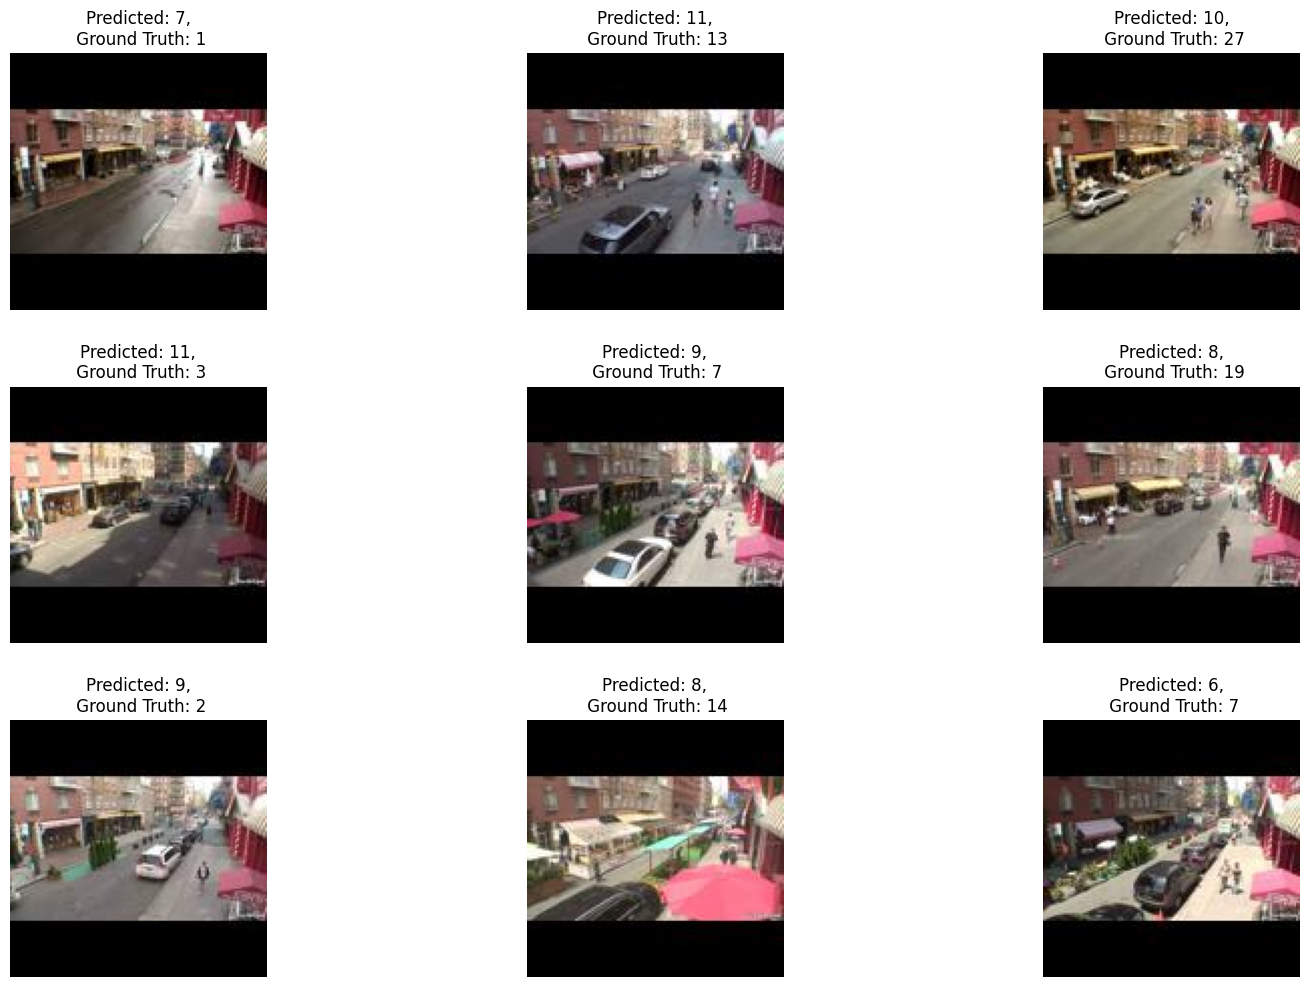

In [9]:
visualize_ground_truth_predictions(cnn_model, '/kaggle/input/earthcam-yolo/ground_truth_New_York_filtered.csv', "New York")